# Deep Q Learning

> Now, we will start with actual Deep Reinforcement Learning and implement a Deep Q Network!

Bellmann equation:

$$
    Q(S_t, A_t) = (1 - \alpha) \cdot Q(S_t, A_t) + \overbrace{\alpha}^\text{learning rate} \cdot \left[r + \overbrace{\gamma}^\text{discount} \underbrace{\max_{a} Q(S_{t+1}, a)}_\text{cumulative future reward}\right]
$$

> **Questions**
> 
> 1. What does the $Q$ function learn?
> 2. How does the discount factor $\gamma$ affect the agent's policy?
> 3. What happens for a discount factor $\gamma = 0$?
> 4. What happens for a discount factor $\gamma = 0.99$?
> 5. What happens for a discount factor $\gamma = 1$?
> 6. For the next state $S_{t+1}$, why do we want to take the action with the maximum $Q$ value?

> **Solution**
>
> 1. Expected cumulative future reward for a given state and each action. 
> 2. With a low discount factor, agent is short-sighted for immediate rewards, with high discount factor agent plays the long game.
> 3. Agent only regards immediate rewards, not looking into the future.
> 4. Agent will look far ahead into the future, acting less greedy for immediate rewards.
> 5. Q function will probably not converge, as future rewards keep accumulating.
> 6. Want to know, what maximum reward we can expect in the future.

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import MSELoss

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# set animations to jshtml to render them in browser
# plt.rcParams["animation.html"] = "jshtml"

SEED = 19
rng = np.random.default_rng(SEED)

def new_seed(rng):
    return rng.integers(10_000).item()

In [2]:
def replay(frames):
    fig, ax = plt.subplots()
    img = ax.imshow(frames[0])
    ax.axis("off")

    def update(frame):
        img.set_data(frame)
        return [img]

    anim = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)
    plt.close(fig)
    return HTML(anim.to_jshtml())



In [3]:
class Agent:
    """Abstract base class for our cart pole agents."""

    def act(self, obs):
        raise NotImplementedError()

In [4]:
def evaluate_agent(agent: Agent, n_episodes=10, rng=None):
    """Evaluate the agent's average performance over multiple episodes."""
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    rng = np.random.default_rng(rng)

    seed = new_seed(rng)
    observation, info = env.reset(seed=seed)

    total_reward = 0
    for i in range(n_episodes):
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action = agent.act(observation)
            # apply the selected action to the environment
            observation, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
        seed = new_seed(rng)
        env.reset(seed=seed)
    env.close()

    return total_reward / n_episodes

In [5]:
def play_episode(agent, seed=19):
    """Run one episode and return replay."""
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    observation, info = env.reset(seed=seed)

    frames = []

    terminated = False
    truncated = False

    while not (terminated or truncated):
        frames.append(env.render())
        action = agent.act(observation)
        # apply the selected action to the environment
        observation, reward, terminated, truncated, info = env.step(action)
    env.close()
    
    return replay(frames)

## The Deep Q Network

In [6]:
class DQN(nn.Module):
    """Our Deep Q Network implemented in PyTorch."""
    def __init__(self, in_dim=4, hidden_dim=64, out_dim=2):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim

        self.layers = nn.Sequential(
            nn.Linear(self.in_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.out_dim)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [7]:
dqn = DQN()

dqn(torch.randn(1, 4))

tensor([[-0.0111, -0.1941]], grad_fn=<AddmmBackward0>)

> **Questions**
>
> 1. What are the 4 inputs of the network?
> 2. What are the 2 outputs of the network?
> 3. Why do we need a ReLU function? Why don't we include a ReLU for the output?

## The Deep Q Agent

In [8]:
class DQNAgent(Agent):
    """An Agent with a policy given by a Deep Q Network."""

    def __init__(self, learning_rate=0.001, discount=0.99, replay_size=10_000, batch_size=64, rng=None):
        self.dqn = DQN()
        self.replay = []
        self.discount = discount
        self.replay_size = replay_size
        self.batch_size = batch_size
        self.rng = np.random.default_rng(rng)
        self.criterion = MSELoss()
        self.optimizer = Adam(self.dqn.parameters(), lr=learning_rate)

    def act(self, obs):
        obs = torch.from_numpy(obs).unsqueeze(0).float()
        with torch.no_grad():
            q = self.dqn(obs)
        # choose action with biggest expected future reward
        action = q.argmax(axis=1).item()
        return action
    
    def remember(self, state, action, next_state, reward):
        """Store experience in the replay buffer."""
        self.replay.append({
            "state": state,
            "action": action,
            "next_state": next_state,
            "reward": reward
        })

        if len(self.replay) > self.replay_size:
            self.replay = self.replay[-self.replay_size:]
    
    def update(self):
        """Update the DQN with experience from the replay buffer."""
        if len(self.replay) < self.batch_size:
            raise RuntimeError("did not gather enough experience yet!")
        # 1. sample past experiences from the replay buffer
        samples = self.rng.choice(self.replay, self.batch_size, replace=False)
        states = torch.stack([torch.from_numpy(sample["state"]).float() for sample in samples])
        next_states = torch.stack([torch.from_numpy(sample["next_state"]).float() for sample in samples])
        actions = torch.tensor([sample["action"] for sample in samples])
        rewards = torch.tensor([sample["reward"] for sample in samples])
        ids = torch.arange(len(samples))
        # 2. predict expected future reward using dqn for current and next state
        with torch.no_grad():
            # although similar, [:, actions] uses broadcasts, we want [ids, actions]
            # q_current = self.dqn(states)[:, actions]
            q_current = self.dqn(states)[ids, actions]
            q_next, _ = self.dqn(next_states).max(axis=1)
        # 3. compute target q value of next iteration
        # we can actually cut the first part, as Adams learning rate will already handle that
        # q_target = (1 - self.learning_rate) * q_current
        q_target = rewards + self.discount * q_next
        # 4. train dqn via gradient descent according to update equation
        y_pred = self.dqn(states)
        y_true = y_pred.detach().clone()
        y_true[ids, actions] = q_target
        loss = self.criterion(y_true, y_pred)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()

## Training

In [9]:
from tqdm import trange

def train_dqn(agent: DQNAgent, n_episodes=100, exploration_start=0.95, exploration_end=0.01, rng=None):
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    rng = np.random.default_rng(rng)
    train_rewards = []
    train_loss = []
    train_len = []

    for i in trange(n_episodes):
        observation, info = env.reset(seed=19)
        terminated = False
        truncated = False
        total_reward = 0
        steps = 0

        # epsilon annealing: linear decay of exploration rate
        exploration_rate = exploration_start + (exploration_end - exploration_start) * (i / n_episodes)

        while not terminated and not truncated:
            steps += 1

            p = rng.random()
            if p <= exploration_rate:
                # select a random action for exploration
                action = env.action_space.sample()
            else:
                # otherwise exploit our agent's knowledge
                action = agent.act(observation)

            # apply the selected action to the environment
            next_observation, reward, terminated, truncated, info = env.step(action)

            if terminated:
                reward = -100
            total_reward += reward

            # TODO: standardize observation and next_observation?
            agent.remember(observation, action, next_observation, reward)
            observation = next_observation

            if len(agent.replay) >= agent.batch_size:
                loss = agent.update()
                train_loss.append(loss)
        
        train_rewards.append(total_reward)
        train_len.append(steps)

    info = {"rewards": train_rewards, "loss": train_loss, "len": train_len}
    return info

> **Questions**
> 
> 1. Compared to the equation, why isn't `q_target` implemented as linear combination of $Q(s_t,a_t)$ and $Q(s_{t+1}, a_{t+1})$?
> 2. What is the idea of epsilon annealing?
> 3. Why do we only assign a negative reward for terminated, but not for truncated?

> **Solution**
>
> 1. We optimize the Deep Q Network using Adam. Adam already has a learning rate parameter, that takes care of slowly integrating new information.
> 2. In the beginning, we want to focus more on *exploration*, to get more information about the environment. Later, we want to shift to *exploiting* the policies we have learned so far and put them to a test.
> 3. If the episode *terminates*, the agent lost because the pole flipped over. But if the episode is *truncated*, the agent won by surviving 500 time steps.

In [10]:
dqn_agent = DQNAgent(learning_rate=1e-3, discount=0.9)
train_info = train_dqn(dqn_agent, n_episodes=100)

100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


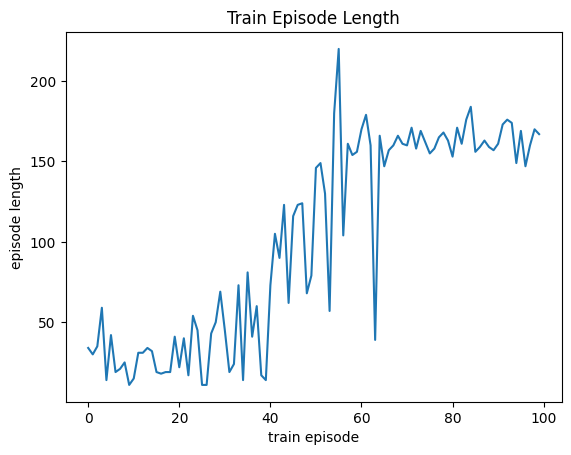

In [11]:
plt.plot(train_info["len"])
plt.xlabel("train episode")
plt.ylabel("episode length")
plt.title("Train Episode Length");

In [12]:
evaluate_agent(dqn_agent)

159.9

In [13]:
play_episode(dqn_agent)

Authorization required, but no authorization protocol specified



## Bookmarks

- [Brockman et al.: "OpenAI Gym" (2016)](https://arxiv.org/abs/1606.01540)
- [The CartPole Environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/)
- [Kaggle Intro to Reinforcement Learning](https://www.kaggle.com/learn/intro-to-game-ai-and-reinforcement-learning)
- [Gymnasium, the successor of OpenAI Gym](https://gymnasium.farama.org/)
- [Gymnasium Tutorials](https://gymnasium.farama.org/tutorials/index.html)